In [23]:
import wandb
wandb.login()

wandb: Currently logged in as: johnwilsonlorin1 (johnwilsonlorin1-laguna-state-polytechnic-university). Use `wandb login --relogin` to force relogin


True

Total number of rows: 658
Correlation with Phytoplankton (cells/ml):
BOD (mg/l)                     0.179928
Ammonia (mg/L)                 0.139569
Inorganic Phosphate (mg/L)     0.129177
Total coliforms (MPN/100ml)    0.087159
Humidity                       0.083127
pH (units)                     0.075345
Temperature                    0.058434
Wind Speed                     0.057731
Name: Phytoplankton (cells/ml), dtype: float64


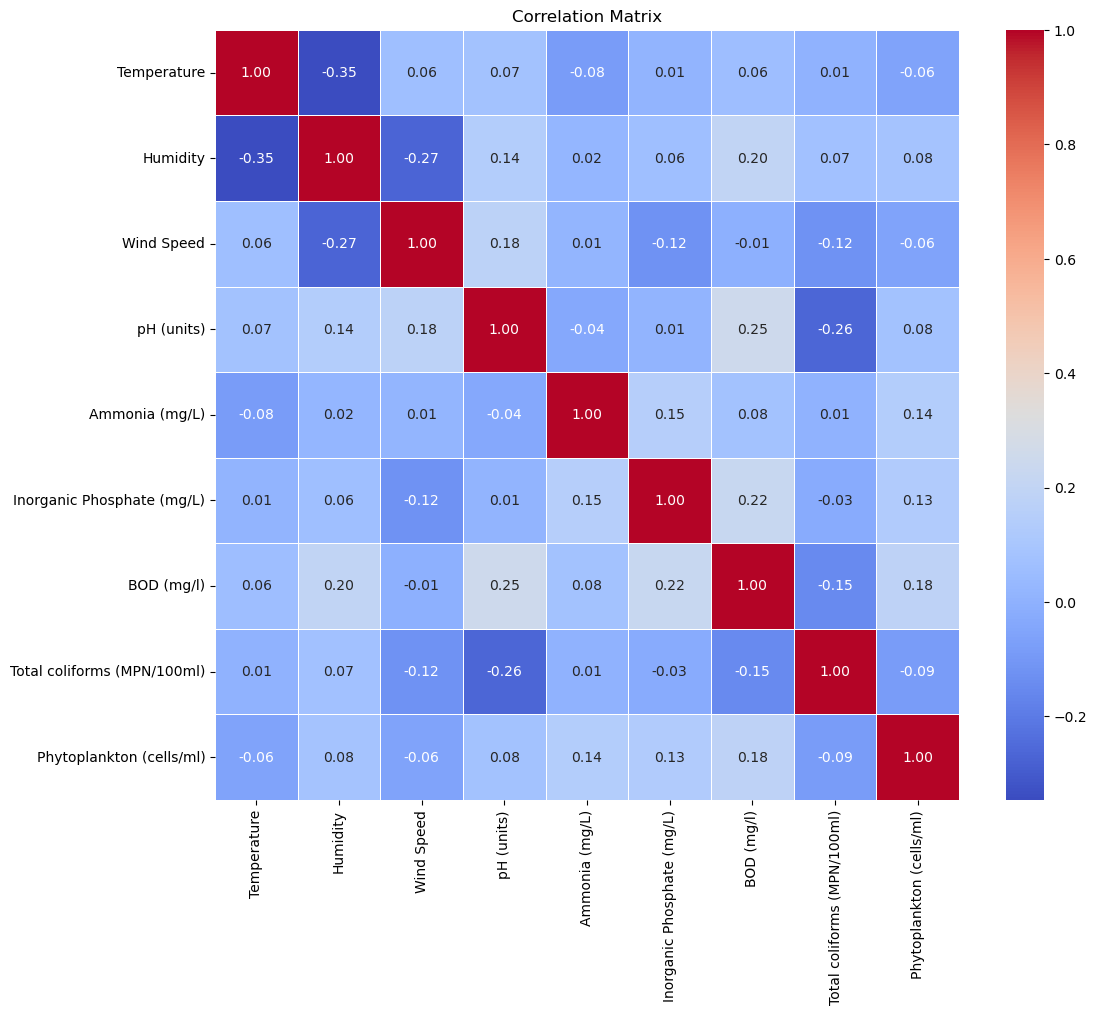

XGBoost - Mean Squared Error: 2969763693.393832
XGBoost - Mean Absolute Error: 31160.81449312152
XGBoost - R^2 Score: 0.617278300770117


MAE,▁
MSE,▁
R2 Score,▁
MAE,31160.81449
MSE,2969763693.39383
R2 Score,0.61728


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
import wandb

# Initialize a new wandb run
wandb.init(project='LLDA-Detecting Algal Blooms and Fish Kill')

# Load datasets with specified encoding
merged_df = pd.read_csv('complete.csv')
merged_df = merged_df.dropna()
row_count = len(merged_df)
print(f'Total number of rows: {row_count}')

# Select relevant features and target
features = ['Temperature', 'Humidity', 'Wind Speed', 'pH (units)', 'Ammonia (mg/L)', 'Inorganic Phosphate (mg/L)', 'BOD (mg/l)', 'Total coliforms (MPN/100ml)']
target = 'Phytoplankton (cells/ml)'

# Combine features and target for correlation analysis
df_for_corr = merged_df[features + [target]]

# Calculate correlation matrix
corr_matrix = df_for_corr.corr()

# Print the correlation values with the target variable
target_corr = corr_matrix[target].drop(target)
sorted_target_corr = target_corr.abs().sort_values(ascending=False)

print("Correlation with Phytoplankton (cells/ml):")
print(sorted_target_corr)

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Drop any remaining missing values
merged_df = merged_df.dropna()

# Split data into training and testing sets
X = merged_df[features]
y = merged_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Gradient Boosting Machine (XGBoost)
xgb_model = XGBRegressor()
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - Mean Squared Error: {mse_xgb}')
print(f'XGBoost - Mean Absolute Error: {mae_xgb}')
print(f'XGBoost - R^2 Score: {r2_xgb}')

# Log hyperparameters and metrics to wandb
wandb.log({
    'MSE': mse_xgb,
    'MAE': mae_xgb,
    'R2 Score': r2_xgb
})

# Finish the wandb run
wandb.finish()


In [11]:
import pickle
# Save the trained model to a file using pickle
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

print("Model saved to 'xgb_model.pkl'")

# Example: Loading and using the saved model
# Load the model from the file
with open('xgb_model.pkl', 'rb') as file:
    loaded_svr_model = pickle.load(file)

# Predict using the loaded model
y_pred_loaded_model = loaded_svr_model.predict(X_test_scaled)

# Evaluate predictions (if necessary)
mse_loaded_model = mean_squared_error(y_test, y_pred_loaded_model)
mae_loaded_model = mean_absolute_error(y_test, y_pred_loaded_model)
r2_loaded_model = r2_score(y_test, y_pred_loaded_model)

print(f'Loaded Model - Mean Squared Error: {mse_loaded_model}')
print(f'Loaded Model - Mean Absolute Error: {mae_loaded_model}')
print(f'Loaded Model - R^2 Score: {r2_loaded_model}')

Model saved to 'xgb_model.pkl'
Loaded Model - Mean Squared Error: 2969763693.393832
Loaded Model - Mean Absolute Error: 31160.81449312152
Loaded Model - R^2 Score: 0.617278300770117


In [13]:
with open('xgb_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)